# Speedup Analysis

This notebook is about **exploring** the effects on the application **performance** of the following parameters:
 - **Number of threads**: the parallelization factor
 - **Batch size**: the number of events to gather before processing them in parallel

### Application interface
The `soccer-monitoring` application exposes the following interface through the command-line

```bash
$ soccer-monitoring -h                                                                                                        
DEBS 2013 - Soccer Monitoring tool:
  -h [ --help ]                   Print this message
  -T [ --time-units ] arg         Frequency of statistics (in seconds)
  -K [ --max-distance ] arg       Maximum distance for ball possession 
                                  eligibility
  -s [ --stream ] arg             Game stream file path
  -m [ --metadata ] arg           Metadata file path
  -t [ --threads ] arg (=0)       Number of threads
  -B [ --batch-size ] arg (=1500) Events batch size (default: auto)
  -o [ --output ] arg             Output file path (default: stdout)
```

### Design of experiment
In order to explore the domain space, we are going to measure the time required _on average_ to process a batch of events, subject to the parameters changing. Concerning the **number of threads** we are testing the values $nb\_threads = \left \{1, 2, 4, 8 \right \}$, while for **batch size** we are testing the values $batch\_size = \left \{1, 10, 10^2, 10^3, 10^4, 10^5, 10^6, 10^7 \right \}$.

As for the other parameters, we keep them fixed
 - Frequency of statistics = $60 s$
 - Maximum distance for ball possession eligibility = $1 m$
 
### Equipment
Macbook Pro Mid-2012 shipping a Intel(R) Core(TM) i7-3615QM CPU @ 2.30GHz.

In [1]:
import numpy as np
import pandas as pd
import re
import subprocess
import matplotlib.pyplot as plt
from pathlib import Path

%matplotlib inline

# Set Notebook running mode:
is_demo = True

In [2]:
args = ['../cmake-build-release/soccer-monitoring', \
        '-T', '60', \
        '-K', '1', \
        '-s', '../test/resources/game_data_start_10_1e7', \
        '-m', '../datasets/preprocessed/metadata']
nb_threads = [1, 2, 4, 8]
batch_size = [int(10 ** x) for x in range(0, 8)]
pattern = r'Processed \d+ seconds of the stream \(~ \d+ events\) in (\d+\.\d+) seconds'
pattern = re.compile(pattern)

## Full space exploration

In [3]:
op_path = Path('./operating_points.npy')
if is_demo and op_path.is_file():
    data = np.load(str(op_path))
else:
    data = np.zeros((len(nb_threads), len(batch_size), 13))
    for i, thread in enumerate(nb_threads):
        for j, size in enumerate(batch_size):
            out = subprocess.run(args=args + ['-t', '{}'.format(thread), '-B', '{}'.format(size)], \
                                 check=True, \
                                 capture_output=True, \
                                 text=True)
            ts = [float(m.group(1)) for m in re.finditer(pattern, out.stdout)]
            data[i, j] = ts

Max speedup: 27.476%
  NbThreads: 4
  BatchSize: 10000000


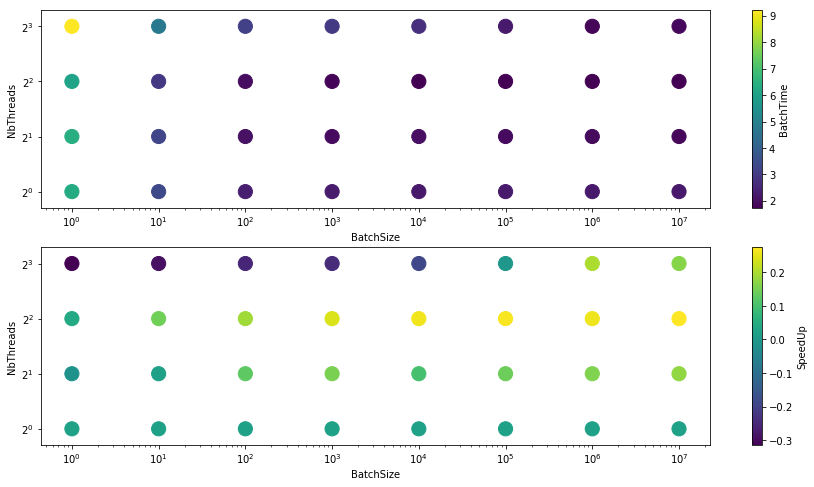

In [4]:
def make_dse_df(data):
    sorted_data = np.sort(data, axis=2)
    batch_time = np.mean(sorted_data[::, ::, 1:-1], axis=2)
    columns = ['1e+{}'.format(x) for x in range(0, 8)]
    index = [str(t) for t in nb_threads]

    df = pd.DataFrame(data=batch_time, columns=columns, index=index)
    speedup = (df.loc['1'] / df) - 1
    speedup.loc['1'] += 2e-2
    speedup = speedup.rename(columns={'BatchTime': 'Speedup'})
    return df, speedup

def make_scatter_df(df, value_col_name):
    scatter_data = []
    for j, col in enumerate(df.columns.tolist()):
        for i, index in enumerate(df.index.tolist()):
            scatter_data += [(2 ** i, 10 ** j, df.at[index, col])]
    columns = ['NbThreads', 'BatchSize', value_col_name]
    return pd.DataFrame(data=scatter_data, columns=columns)

exec_time, speedup = make_dse_df(data)
exec_time_scatter = make_scatter_df(exec_time, 'BatchTime')
speedup_scatter = make_scatter_df(speedup, 'SpeedUp')

plt.figure(figsize=(15, 8))
plt.clf()

ax = plt.subplot(211)
ax.set_yscale('log', basey=2)
exec_time_scatter.plot.scatter(x='BatchSize', y='NbThreads', c='BatchTime', s=200, logx=True, colormap='viridis', ax=ax)

ax = plt.subplot(212)
ax.set_yscale('log', basey=2)
speedup_scatter.plot.scatter(x='BatchSize', y='NbThreads', c='SpeedUp', s=200, logx=True, colormap='viridis', ax=ax)

idx_max = speedup_scatter.idxmax()
max_point = speedup_scatter.iloc[idx_max['SpeedUp']]
max_nb_threads = int(max_point['NbThreads'])
max_batch_size = int(max_point['BatchSize'])
print('Max speedup: {:1.3f}%'.format(max_point['SpeedUp'] * 100))
print('  NbThreads: {:d}'.format(max_nb_threads))
print('  BatchSize: {:d}'.format(max_batch_size))

In [5]:
# Store computed operating points
if not op_path.is_file():
    np.save(str(op_path), data)

## Batch size analysis

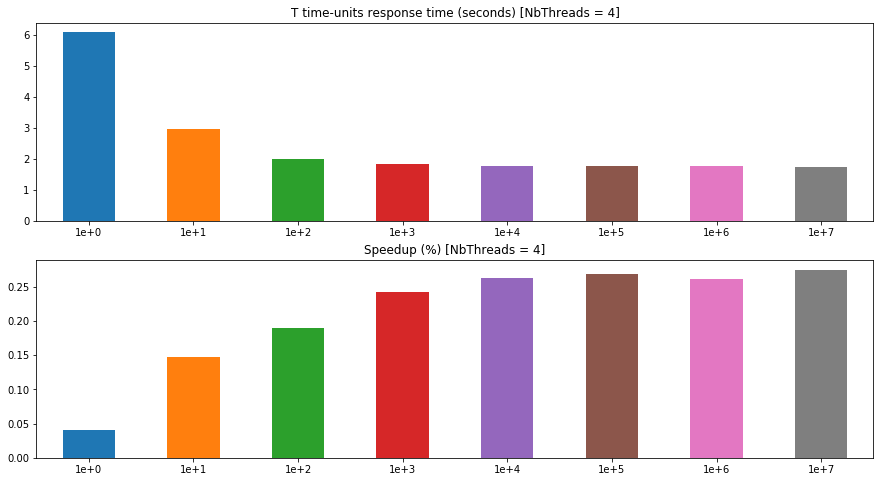

In [6]:
idx = max_nb_threads
exec_time_t = exec_time.loc[str(idx)]
speedup_t = speedup.loc[str(idx)]

plt.figure(figsize=(15, 8))
plt.clf()

ax = plt.subplot(211)
exec_time_t.plot.bar(y='BatchTime', legend=False, title='T time-units response time (seconds) [NbThreads = {}]'.format(max_nb_threads), rot=0, ax=ax)

ax = plt.subplot(212)
speedup_t.plot.bar(y='Speedup', legend=False, title='Speedup (%) [NbThreads = {}]'.format(max_nb_threads), rot=0, ax=ax)

## Number of threads analysis

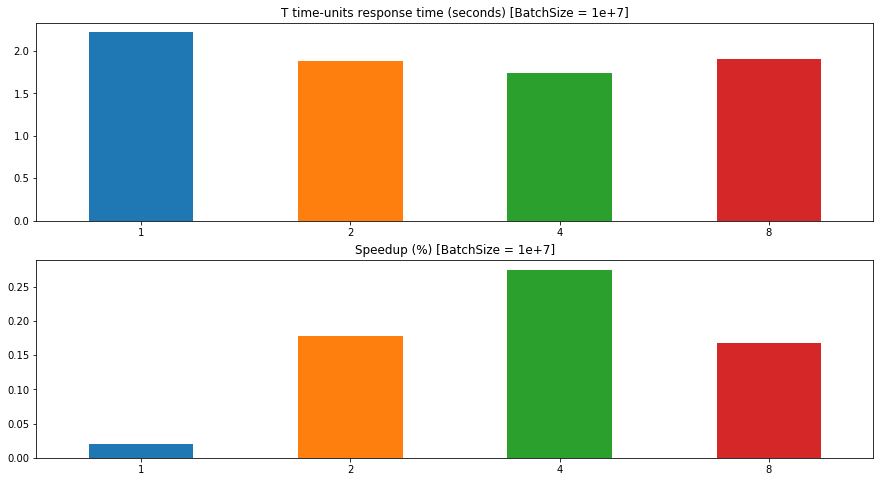

In [7]:
col = '1e+{}'.format(int(np.log10(max_batch_size)))
exec_time_b = exec_time[col]
speedup_b = speedup[col]

plt.figure(figsize=(15, 8))
plt.clf()

ax = plt.subplot(211)
exec_time_b.plot.bar(y='BatchTime', legend=False, title='T time-units response time (seconds) [BatchSize = {}]'.format(col), rot=0, ax=ax)

ax = plt.subplot(212)
speedup_b.plot.bar(y='Speedup', legend=False, title='Speedup (%) [BatchSize = {}]'.format(col), rot=0, ax=ax)